In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("main_df.csv", low_memory=False)

In [3]:
df.head(1)

,acn,trans_id,timestamp,item,item_group,total,membership,group,city,state,zipcode,lat,long,category
0,11,37777,2015-08-12 16:03:00,Core Power,Beverage,2.8,Misc. Membership,NaN,NaN,NaN,NaN,NaN,NaN,Bar


In [4]:
df.acn.nunique()

2725

In [103]:
itemized = pd.pivot_table(df, values="total",index="acn",columns="item_group",aggfunc="sum",fill_value=0)

In [104]:
itemized.columns

Index(['24 Hour of Tennis', 'Accessories', 'Adult Clinics', 'Apparel', 'Beer',
       'Beverage', 'Camp', 'Court Time', 'Date Night', 'Dinners',
       'Facility Rental', 'Fitness Lessons', 'Fitness Special Event',
       'Food & Consumables', 'Food Allowance', 'Guest Fee',
       'Homeowner Membership Initiation', 'Junior Clinics', 'Kid Fit',
       'Leagues', 'Membership Dues', 'Membership Initiation',
       'Personal Training', 'Racquet Rental', 'Racquets',
       'Restring/ Labor Only', 'Shoes', 'Social Event', 'Special Event',
       'Sponsorship', 'String', 'Swim Camp', 'Swim Lessons',
       'Teen Performance Camp', 'Tennis Balls', 'Tennis Lessons', 'Wine'],
      dtype='object', name='item_group')

---

## Are there perceivable segments based on location and median spend?

In [46]:
loc_spend = df[(df.lat.notna()) & (df.lat.notna())]
loc_spend = df[["acn","lat","long","total"]]
loc_spend = loc_spend.groupby(["acn","lat","long"])[["total"]].sum().reset_index().set_index("acn").drop(2512,axis=0)

In [47]:
loc_spend.head()

,lat,long,total
acn,,,
1303,29.714595,-98.285693,1675.85
1317,29.719981,-98.200992,232.38
1320,29.713125,-98.203599,1858.99
1321,29.719981,-98.200992,10.00
1322,29.739218,-98.207010,60.00


In [56]:
loc_spend = loc_spend[loc_spend.long <= -98]

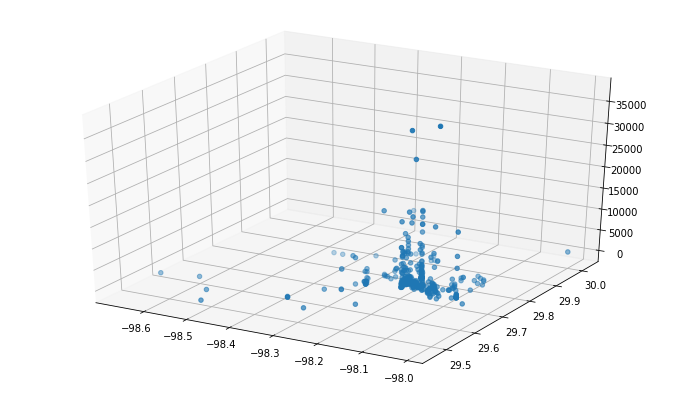

In [57]:
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111, projection='3d')

# Plot models:
ax.scatter(loc_spend.long,loc_spend.lat,loc_spend.total)

## KMeans Clustering

In [95]:
from sklearn.cluster import KMeans

In [119]:
kmeans = KMeans(n_clusters=5)
clusters = kmeans.fit_predict(itemized)

In [120]:
clusters = pd.DataFrame(index=itemized.index, data=kmeans.labels_,columns=["cluster"])

In [121]:
with_clusters = itemized.join(clusters)

In [122]:
with_clusters.cluster.value_counts()

0    2357
1     230
4     127
2      10
3       1
Name: cluster, dtype: int64

In [126]:
with_clusters["Grand Total"] = with_clusters.sum(axis=1)

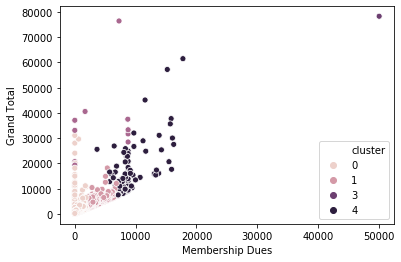

In [129]:
sns.scatterplot(x="Membership Dues",y="Grand Total",data=with_clusters, hue="cluster")

In [174]:
categorical = pd.pivot_table(df, values="total",index="acn",columns="category",aggfunc="sum",fill_value=0)
categorical["Grand Total"] = categorical.sum(axis=1)

In [175]:
categorical = categorical.join(clusters)

In [176]:
categorical.head()

,Admin,Bar,Event,Fitness,Pro Shop,Program,Tennis,Grand Total,cluster
acn,,,,,,,,,
11,0.00,801.58,80.00,0.0,95.12,90.0,208.30,1275.00,0
17,0.00,9.50,0.00,0.0,10.00,0.0,30.00,49.50,0
23,0.00,1015.45,0.00,0.0,10.83,0.0,1614.26,2640.54,0
33,3341.25,247.31,105.12,0.0,52.94,0.0,36.00,3782.62,1
34,5231.80,14.28,2552.20,0.0,0.00,0.0,0.00,7798.28,1


In [177]:
categorical.cluster.value_counts()

0    2357
1     230
4     127
2      10
3       1
Name: cluster, dtype: int64

In [178]:
condition = [categorical.cluster == 0, categorical.cluster == 1, categorical.cluster == 2, categorical.cluster == 3, categorical.cluster == 4]
choice = ["one","two","three","four","five"]
categorical["cluster_label"] = np.select(condition,choice,0)

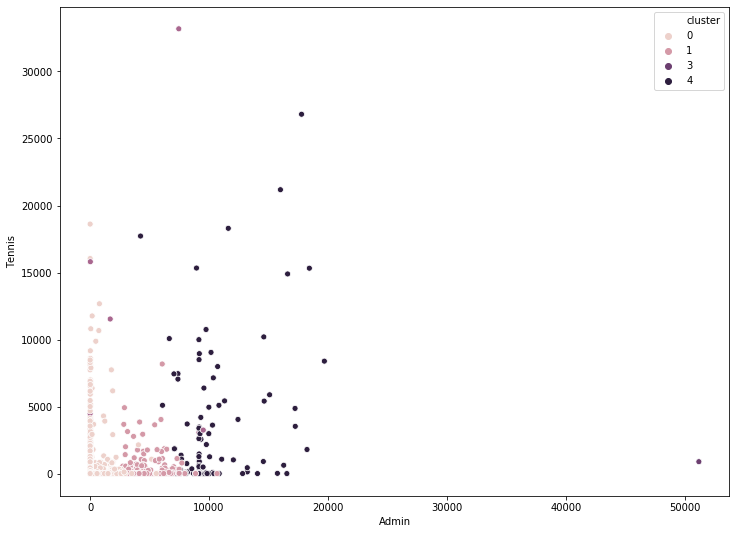

In [179]:
plt.figure(figsize=(12,9))
sns.scatterplot(x="Admin",y="Tennis",data=categorical, hue="cluster")

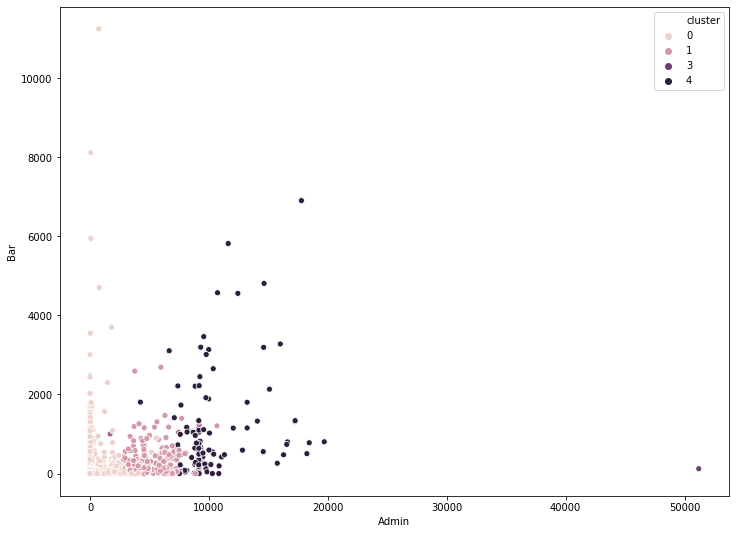

In [180]:
plt.figure(figsize=(12,9))
sns.scatterplot(x="Admin",y="Bar",data=categorical, hue="cluster")

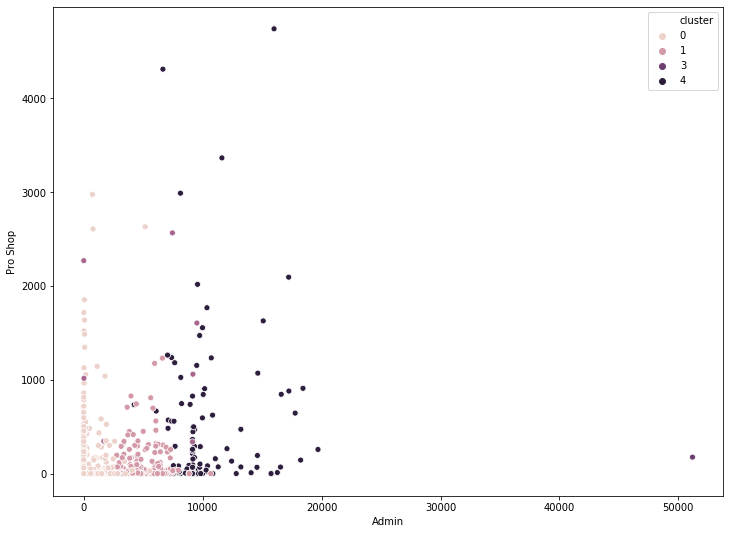

In [181]:
plt.figure(figsize=(12,9))
sns.scatterplot(x="Admin",y="Pro Shop",data=categorical, hue="cluster")

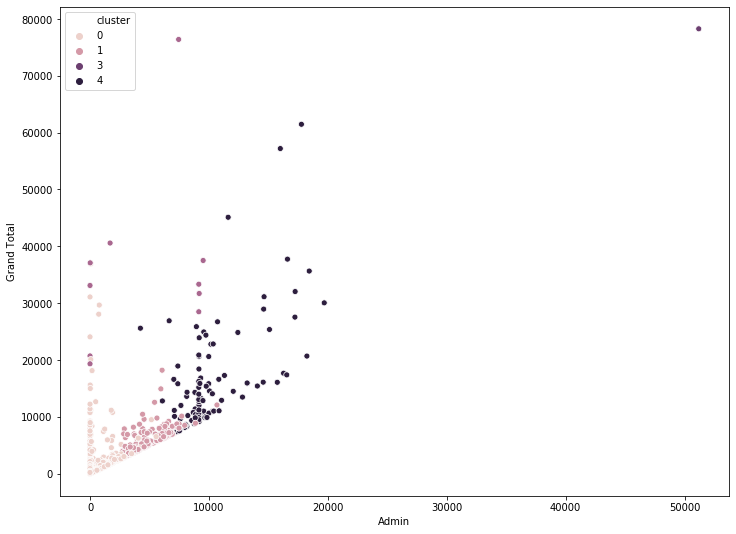

In [182]:
plt.figure(figsize=(12,9))
sns.scatterplot(x="Admin",y="Grand Total",data=categorical, hue="cluster")

Text(0.5, 0, 'Grand Total')

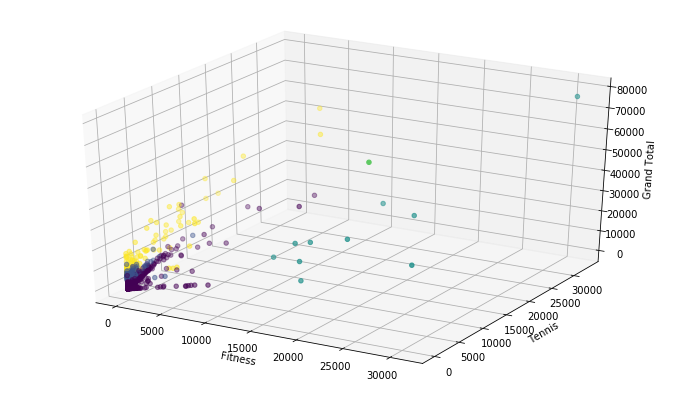

In [191]:
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111, projection='3d')

# Plot models:

ax.scatter(categorical["Fitness"], categorical["Tennis"], categorical["Grand Total"],c=categorical.cluster.astype(np.float))

ax.set_xlabel('Fitness')
ax.set_ylabel('Tennis')
ax.set_zlabel('Grand Total')

### Clusters separated based on (1) Grand Total, (2) Atypically High Fitness and High Tennis

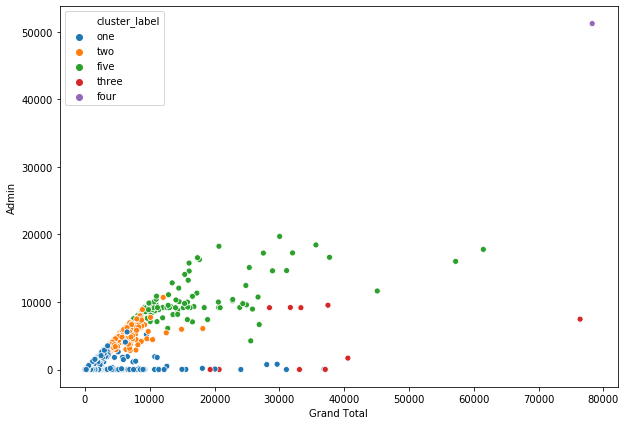

In [196]:
plt.figure(figsize=(10,7))
sns.scatterplot(x="Grand Total",y="Admin", hue="cluster_label",data=categorical)

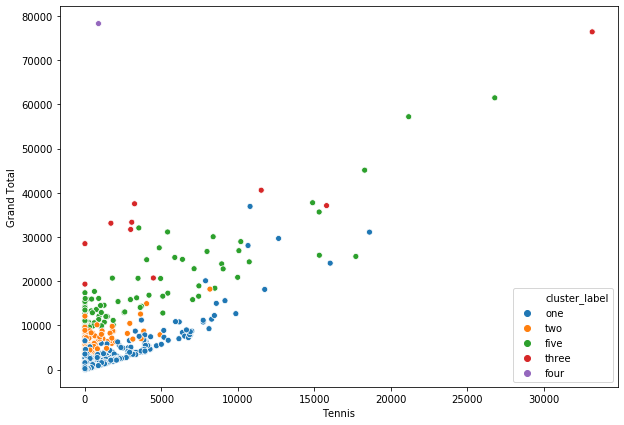

In [198]:
plt.figure(figsize=(10,7))
sns.scatterplot(x="Tennis",y="Grand Total", hue="cluster_label",data=categorical)

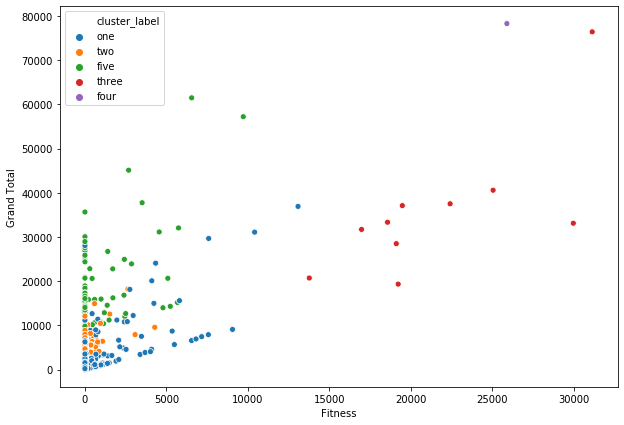

In [199]:
plt.figure(figsize=(10,7))
sns.scatterplot(x="Fitness",y="Grand Total", hue="cluster_label",data=categorical)

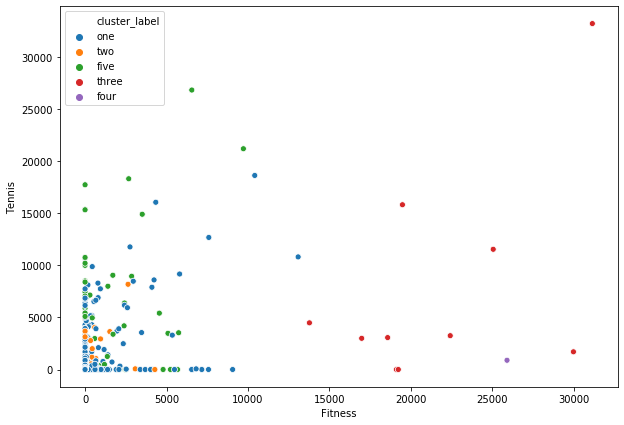

In [200]:
plt.figure(figsize=(10,7))
sns.scatterplot(x="Fitness",y="Tennis", hue="cluster_label",data=categorical)

In [230]:
threes = list(categorical[categorical.cluster_label=="three"].index)

In [221]:
mem = pd.read_csv("cl_member.csv")

In [232]:
mem[mem.acn.isin(threes)]

,Unnamed: 0,trans_id,timestamp,name,item,item_group,status,quantity,subtotal,discount,tax,total,paid,refund,balance,acn,sys_id
55,55,37774,2015-08-12 15:52:00,Mike Shellman,Lessons with Joe Snailum (08/08/2015),Lessons,Paid,1.0,55.00,0.00,0.00,55.00,55.00,0.0,0.0,127,General Family Membership
115,115,38027,2015-08-18 08:30:00,Mike Shellman,Lessons with Joe Snailum (08/18/2015),Lessons,Paid,1.0,55.00,0.00,0.00,55.00,55.00,0.0,0.0,127,General Family Membership
172,172,37912,2015-08-15 09:43:00,Mark Kneuper,Group Event: Open Clinic (08/15/2015),Adult Clinics,Paid,1.0,25.00,0.00,0.00,25.00,25.00,0.0,0.0,227,General Property Owner
173,173,37912,2015-08-15 09:43:00,Mark Kneuper,Group Event: Open Clinic (08/15/2015),Adult Clinics,Paid,1.0,25.00,0.00,0.00,25.00,25.00,0.0,0.0,227,General Family Membership
174,174,37911,2015-08-15 09:42:00,Jean Kneuper,Group Event: Open Clinic (08/15/2015),Adult Clinics,Paid,1.0,25.00,0.00,0.00,25.00,25.00,0.0,0.0,940,General Property Owner
175,175,37911,2015-08-15 09:42:00,Jean Kneuper,Group Event: Open Clinic (08/15/2015),Adult Clinics,Paid,1.0,25.00,0.00,0.00,25.00,25.00,0.0,0.0,940,General Family Membership
186,186,37594,2015-08-10 08:17:00,Travis Wuest,Dasani Water bottle,Drinks,Paid,1.0,1.62,0.00,0.13,1.75,1.75,0.0,0.0,244,General Family Membership
187,187,37593,2015-08-10 08:17:00,Travis Wuest,Core Power,Drinks,Paid,1.0,3.46,0.00,0.29,3.75,3.75,0.0,0.0,244,General Family Membership
188,188,37592,2015-08-13 08:30:00,Mike Shellman,Lessons with Joe Snailum (08/13/2015),Lessons,Paid,1.0,55.00,0.00,0.00,55.00,55.00,0.0,0.0,127,General Family Membership
191,191,37578,2015-08-10 07:22:00,Travis Wuest,Group Event: Early Bird Drills (08/10/2015),Adult Clinics,Paid,1.0,15.00,0.00,0.00,15.00,15.00,0.0,0.0,244,General Family Membership


In [225]:
df[df.acn==343]

,acn,trans_id,timestamp,item,item_group,total,membership,group,city,state,zipcode,lat,long,category
44539,343,36620,2015-07-31 00:00:00,Membership for &quot;General Family Membership...,Membership Dues,422.18,General Single Membership,NaN,NaN,NaN,NaN,NaN,NaN,Admin
44540,343,36658,2015-07-31 00:00:00,Membership for &quot;Premier Family Membership...,Membership Dues,140.73,Premier Family Membership,NaN,NaN,NaN,NaN,NaN,NaN,Admin
44541,343,36658,2015-07-31 00:00:00,Membership for &quot;Premier Family Membership...,Membership Dues,140.73,General Family Membership,NaN,NaN,NaN,NaN,NaN,NaN,Admin
44542,343,36658,2015-07-31 00:00:00,Membership for &quot;Premier Family Membership...,Membership Dues,140.73,General Single Membership,NaN,NaN,NaN,NaN,NaN,NaN,Admin
44543,343,36620,2015-07-31 00:00:00,Membership for &quot;General Family Membership...,Membership Dues,422.18,General Family Membership,NaN,NaN,NaN,NaN,NaN,NaN,Admin
44544,343,36620,2015-07-31 00:00:00,Membership for &quot;General Family Membership...,Membership Dues,422.18,Premier Family Membership,NaN,NaN,NaN,NaN,NaN,NaN,Admin
44545,343,40626,2015-08-31 00:00:00,Membership for &quot;Premier Family Membership...,Membership Dues,140.73,Premier Family Membership,NaN,NaN,NaN,NaN,NaN,NaN,Admin
44546,343,40626,2015-08-31 00:00:00,Membership for &quot;Premier Family Membership...,Membership Dues,140.73,General Family Membership,NaN,NaN,NaN,NaN,NaN,NaN,Admin
44547,343,40626,2015-08-31 00:00:00,Membership for &quot;Premier Family Membership...,Membership Dues,140.73,General Single Membership,NaN,NaN,NaN,NaN,NaN,NaN,Admin
44548,343,40585,2015-08-31 00:00:00,Membership for &quot;General Family Membership...,Membership Dues,422.18,Premier Family Membership,NaN,NaN,NaN,NaN,NaN,NaN,Admin


### Clusters three and four are the high fitness clusters

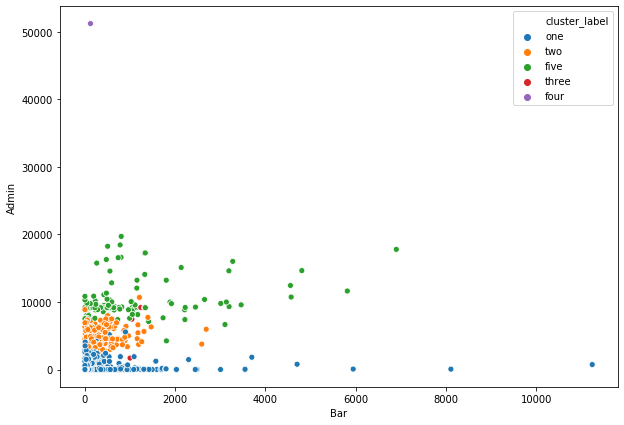

In [212]:
plt.figure(figsize=(10,7))
sns.scatterplot(x="Bar",y="Admin", hue="cluster_label",data=categorical)

### Maybe? Clusters one, two, and five are just differences in Admin Total

<BarContainer object of 2725 artists>

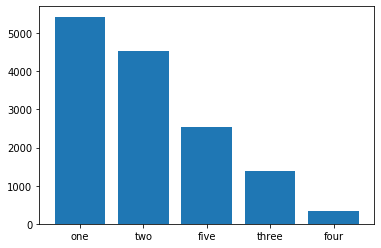

In [213]:
plt.bar(x="cluster_label",height=categorical.index,data=categorical)

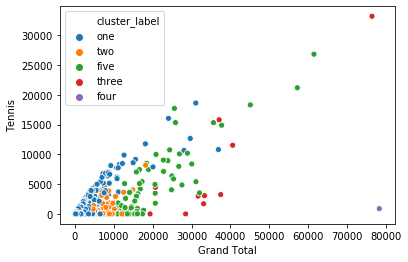

In [214]:
sns.scatterplot(x="Grand Total",y="Tennis",data=categorical,hue="cluster_label")

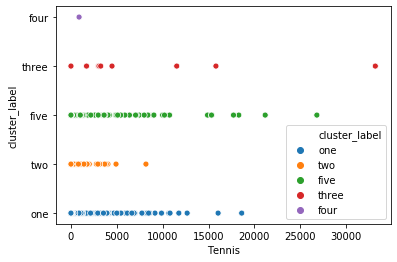

In [215]:
sns.scatterplot(x="Tennis",y="cluster_label",data=categorical,hue="cluster_label")

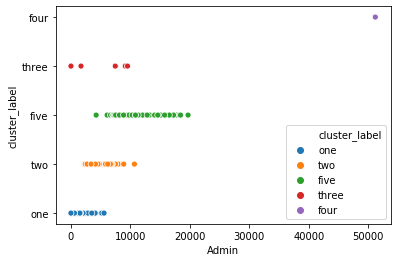

In [216]:
sns.scatterplot(x="Admin",y="cluster_label",data=categorical,hue="cluster_label")

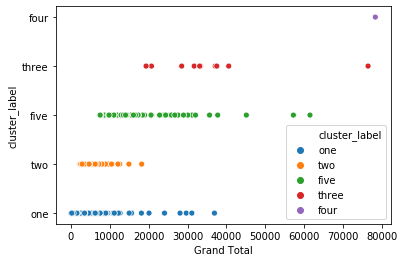

In [217]:
sns.scatterplot(x="Grand Total",y="cluster_label",data=categorical,hue="cluster_label")

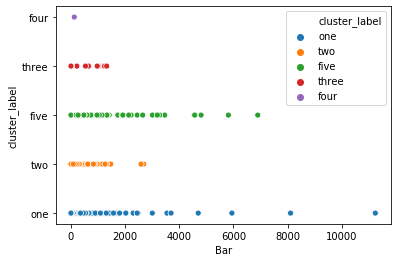

In [218]:
sns.scatterplot(x="Bar",y="cluster_label",data=categorical,hue="cluster_label")

### Cluster One - Low Admin, Mid Grand Total, High Bar
### Cluster Two - Mid Admin, Low Grand Total, Low Bar
### Cluster Five - High Admin, High Grand Total, Mid Bar

In [219]:
df.head()

,acn,trans_id,timestamp,item,item_group,total,membership,group,city,state,zipcode,lat,long,category
0,11,37777,2015-08-12 16:03:00,Core Power,Beverage,2.80,Misc. Membership,NaN,NaN,NaN,NaN,NaN,NaN,Bar
1,11,38361,2015-08-21 08:02:00,Berries Amore,Beverage,4.28,Misc. Membership,NaN,NaN,NaN,NaN,NaN,NaN,Bar
2,11,38360,2015-08-21 08:02:00,Smoothie Add-On,Beverage,0.67,Misc. Membership,NaN,NaN,NaN,NaN,NaN,NaN,Bar
3,11,35130,2015-07-24 11:53:00,$2.00 Ice Cream,Food & Consumables,2.00,Misc. Membership,NaN,NaN,NaN,NaN,NaN,NaN,Bar
4,11,35131,2015-07-24 11:53:00,$2.00 Ice Cream,Food & Consumables,2.00,Misc. Membership,NaN,NaN,NaN,NaN,NaN,NaN,Bar


## Clustering Isolating Activities

In [362]:
act_only = df[df.category.isin(["Tennis","Program","Event","Fitness"])]

In [363]:
itemized_act = pd.pivot_table(act_only,values="total",index="acn",columns="item_group",fill_value=0,aggfunc=sum)

In [364]:
itemized_act["Grand Total"] = itemized_act.sum(axis=1)

In [365]:
kmeans = KMeans(n_clusters=6)
clusters = kmeans.fit_predict(itemized_act)
clusters = pd.DataFrame(index=itemized_act.index, data=kmeans.labels_,columns=["cluster"])

In [366]:
act_cluster = itemized_act.join(clusters)

In [367]:
act_cluster.cluster.value_counts()

0    1780
5     111
4      36
2       9
1       9
3       1
Name: cluster, dtype: int64

In [370]:
act_only = act_only.set_index("acn")
act_only = act_only.pivot_table(values="total",index=act_only.index,columns="category",aggfunc=sum,fill_value=0)
activity = act_only.join(act_cluster)

In [371]:
activity.head()

,Event,Fitness,Program,Tennis,24 Hour of Tennis,Adult Clinics,Camp,Court Time,Date Night,Dinners,...,Leagues,Personal Training,Social Event,Special Event,Swim Camp,Swim Lessons,Teen Performance Camp,Tennis Lessons,Grand Total,cluster
acn,,,,,,,,,,,,,,,,,,,,,
11,80.00,0.0,90.0,208.30,0.0,24.30,0.0,0.0,35.0,0.00,...,0.0,0.0,0.0,45.00,0,90,0.0,184.00,378.30,0
17,0.00,0.0,0.0,30.00,0.0,30.00,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.00,0,0,0.0,0.00,30.00,0
23,0.00,0.0,0.0,1614.26,0.0,0.01,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.00,0,0,0.0,1614.25,1614.26,0
33,105.12,0.0,0.0,36.00,0.0,36.00,0.0,0.0,0.0,12.99,...,0.0,0.0,0.0,92.13,0,0,0.0,0.00,141.12,0
34,2552.20,0.0,0.0,0.00,0.0,0.00,0.0,0.0,52.2,0.00,...,0.0,0.0,0.0,0.00,0,0,0.0,0.00,2552.20,0


In [372]:
condition = [activity.cluster == 0, activity.cluster == 1, activity.cluster == 2, activity.cluster == 3, activity.cluster == 4, activity.cluster == 5]
choice = ["one","two","three","four","five","six"]
activity["cluster_label"] = np.select(condition,choice,0)

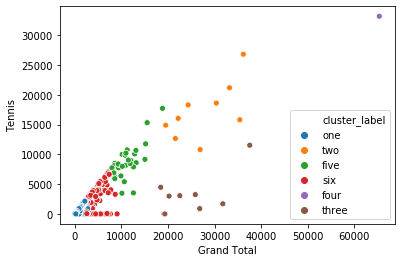

In [373]:
sns.scatterplot(data=activity,x="Grand Total",y="Tennis",hue="cluster_label")

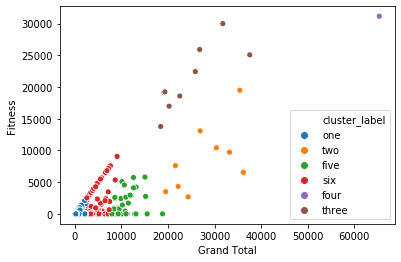

In [374]:
sns.scatterplot(data=activity,x="Grand Total",y="Fitness",hue="cluster_label")

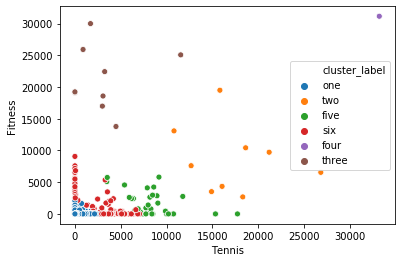

In [375]:
sns.scatterplot(data=activity,x="Tennis",y="Fitness",hue="cluster_label")

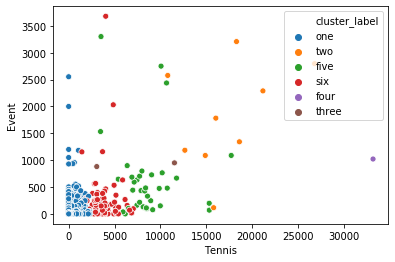

In [376]:
sns.scatterplot(data=activity,x="Tennis",y="Event",hue="cluster_label")

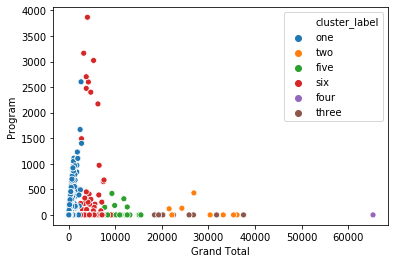

In [378]:
sns.scatterplot(data=activity,x="Grand Total",y="Program",hue="cluster_label")

## Cluster Two - High Tennis and/or Event
## Cluster Four - High Fitness

In [379]:
ot = activity[activity.cluster_label.isin(["one","three"])]

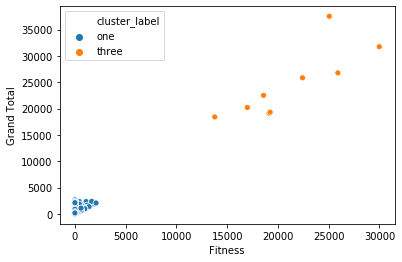

In [380]:
sns.scatterplot(data=ot,x="Fitness",y="Grand Total",hue="cluster_label")

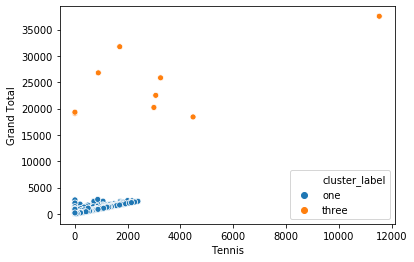

In [381]:
sns.scatterplot(data=ot,x="Tennis",y="Grand Total",hue="cluster_label")

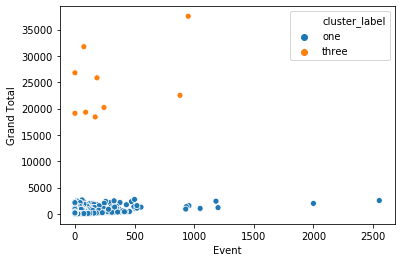

In [382]:
sns.scatterplot(data=ot,x="Event",y="Grand Total",hue="cluster_label")

In [383]:
ot.head()

,Event,Fitness,Program,Tennis,24 Hour of Tennis,Adult Clinics,Camp,Court Time,Date Night,Dinners,...,Personal Training,Social Event,Special Event,Swim Camp,Swim Lessons,Teen Performance Camp,Tennis Lessons,Grand Total,cluster,cluster_label
acn,,,,,,,,,,,,,,,,,,,,,
11,80.00,0.0,90.0,208.30,0.0,24.30,0.0,0.0,35.0,0.00,...,0.0,0.0,45.00,0,90,0.0,184.00,378.30,0,one
17,0.00,0.0,0.0,30.00,0.0,30.00,0.0,0.0,0.0,0.00,...,0.0,0.0,0.00,0,0,0.0,0.00,30.00,0,one
23,0.00,0.0,0.0,1614.26,0.0,0.01,0.0,0.0,0.0,0.00,...,0.0,0.0,0.00,0,0,0.0,1614.25,1614.26,0,one
33,105.12,0.0,0.0,36.00,0.0,36.00,0.0,0.0,0.0,12.99,...,0.0,0.0,92.13,0,0,0.0,0.00,141.12,0,one
34,2552.20,0.0,0.0,0.00,0.0,0.00,0.0,0.0,52.2,0.00,...,0.0,0.0,0.00,0,0,0.0,0.00,2552.20,0,one


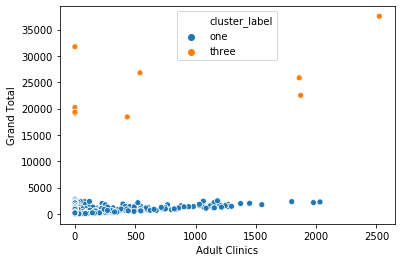

In [384]:
sns.scatterplot(data=ot,x="Adult Clinics",y="Grand Total",hue="cluster_label")

---

In [550]:
norm = df[df.category!="Admin"]

# Time Series

In [551]:
norm.timestamp = pd.to_datetime(norm.timestamp)

In [552]:
dt = norm.set_index("timestamp")

## Monthly Average per user

In [553]:
monthly = dt.groupby("acn").resample("M")[["total"]].median().reset_index()
monthly.fillna(0,inplace=True)

In [554]:
monthly["month"] = monthly.timestamp.dt.strftime("%m")

In [555]:
monthly_average = monthly.groupby(["acn","month"])[["total"]].median()

In [556]:
kmeans = KMeans(n_clusters=5)
clusters = kmeans.fit_predict(monthly_average)
clusters = pd.DataFrame(index=monthly_average.index, data=kmeans.labels_,columns=["cluster"])

In [557]:
monthly_average = monthly_average.copy().join(clusters)

In [558]:
monthly_average.reset_index(inplace=True)

In [559]:
monthly_average.cluster.value_counts()

1    15284
0     2159
4      746
2      232
3        1
Name: cluster, dtype: int64

In [560]:
condition = [monthly_average.cluster == 0, monthly_average.cluster == 1, monthly_average.cluster == 2, monthly_average.cluster == 3, monthly_average.cluster == 4]
choice = ["one","two","three","four","five"]
monthly_average["cluster_label"] = np.select(condition,choice,0)

In [561]:
# condition = [monthly_average.cluster == 0, monthly_average.cluster == 1, monthly_average.cluster == 2, monthly_average.cluster == 3, monthly_average.cluster == 4, monthly_average.cluster == 5,monthly_average.cluster == 6,monthly_average.cluster == 7]
# choice = ["one","two","three","four","five","six","seven","eight"]
# monthly_average["cluster_label"] = np.select(condition,choice,0)

In [562]:
# pd.pivot_table(data=monthly_average,index="acn",values="total",columns="cluster",aggfunc=np.median)

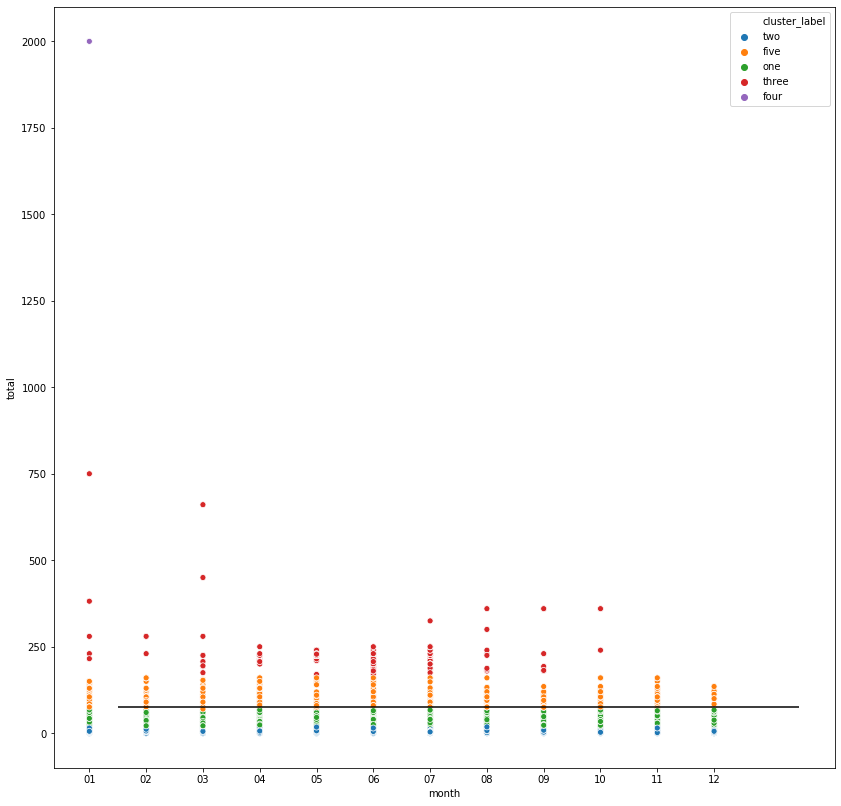

In [563]:
plt.figure(figsize=(14,14))
sns.scatterplot(data=monthly_average,x="month",y="total",hue="cluster_label")

plt.hlines(y=monthly_average.total.quantile(.95),xmin=0.5,xmax=12.5)

In [564]:
monthly_average.total.quantile(.75)

8.66

In [581]:
monthly_average

acn                11
month              12
total            3.56
cluster             1
cluster_label     two
Name: 11, dtype: object

In [601]:
monthly_cluster = monthly_average.groupby(["acn","cluster_label"])[["cluster_label"]].count().rename(columns={"cluster_label":"count"}).sort_values(by=["acn","count"],ascending=False).reset_index()

In [609]:
monthly_cluster = monthly_cluster.drop_duplicates(subset="acn",keep="first").drop(columns="count")
monthly_cluster.set_index("acn",inplace=True)

In [628]:
monthly_cluster.shape

(2567, 1)

In [618]:
norm.set_index("acn",inplace=True)

In [620]:
norm = norm.join(monthly_cluster)

In [637]:
by_cat = category.copy()
by_cat["Grand Total"] = by_cat.sum(axis=1)

In [638]:
by_cat = by_cat.join(monthly_cluster).fillna({"cluster_label":"admin_only"})

In [641]:
by_cat[by_cat.cluster_label=="admin_only"]

,Admin,Bar,Event,Fitness,Pro Shop,Program,Tennis,Grand Total,cluster_label
acn,,,,,,,,,
64,2673.87,0.0,0.0,0.0,0.0,0.0,0.0,2673.87,admin_only
68,1548.03,0.0,0.0,0.0,0.0,0.0,0.0,1548.03,admin_only
70,562.92,0.0,0.0,0.0,0.0,0.0,0.0,562.92,admin_only
72,2955.33,0.0,0.0,0.0,0.0,0.0,0.0,2955.33,admin_only
85,281.46,0.0,0.0,0.0,0.0,0.0,0.0,281.46,admin_only
86,985.11,0.0,0.0,0.0,0.0,0.0,0.0,985.11,admin_only
90,985.11,0.0,0.0,0.0,0.0,0.0,0.0,985.11,admin_only
94,281.46,0.0,0.0,0.0,0.0,0.0,0.0,281.46,admin_only
96,1829.49,0.0,0.0,0.0,0.0,0.0,0.0,1829.49,admin_only


---

# Feb 4 - Customer Lifetime Value

In [611]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

In [612]:
df = pd.read_csv("main_df.csv", low_memory=False)

In [613]:
df.head()

,acn,trans_id,timestamp,item,item_group,total,membership,group,city,state,zipcode,lat,long,category
0,11,37777,2015-08-12 16:03:00,Core Power,Beverage,2.80,Misc. Membership,NaN,NaN,NaN,NaN,NaN,NaN,Bar
1,11,38361,2015-08-21 08:02:00,Berries Amore,Beverage,4.28,Misc. Membership,NaN,NaN,NaN,NaN,NaN,NaN,Bar
2,11,38360,2015-08-21 08:02:00,Smoothie Add-On,Beverage,0.67,Misc. Membership,NaN,NaN,NaN,NaN,NaN,NaN,Bar
3,11,35130,2015-07-24 11:53:00,$2.00 Ice Cream,Food & Consumables,2.00,Misc. Membership,NaN,NaN,NaN,NaN,NaN,NaN,Bar
4,11,35131,2015-07-24 11:53:00,$2.00 Ice Cream,Food & Consumables,2.00,Misc. Membership,NaN,NaN,NaN,NaN,NaN,NaN,Bar


In [614]:
df.shape

(141967, 14)

In [615]:
df.total.describe()
#max is ~3500k

count    141967.000000
mean         38.659745
std          71.270538
min           0.010000
25%           3.750000
50%          10.830000
75%          48.710000
max        3464.000000
Name: total, dtype: float64

There are entries > $2000 and are typically entered as a membership initiation. This is OK because when looking at RFM, frequency will gather less weight if the high-value spend is a one-time thing. 

In [616]:
df.timestamp = pd.to_datetime(df.timestamp)

## Recency

1. Group by acn and get max transaction date (most recent)
2. Calculate recency by subtracting the df's most recent transaction - acn's max purchase date in days

In [606]:
customer = df.groupby('acn')[["timestamp"]].max()

In [607]:
#latest POS purchase
customer.timestamp.max()

Timestamp('2019-12-31 18:23:00')

In [608]:
customer["recency"] = (customer.timestamp.max() - customer.timestamp.min()).dt.days

AttributeError: 'Timedelta' object has no attribute 'dt'

`recency` of 0 is very recent

Now, let's see the most optimal clusters using elbow method.

In [609]:
customer.head()

,timestamp
acn,
11,2019-12-31 14:01:00
17,2015-04-04 11:32:00
23,2019-12-20 12:10:00
33,2019-12-31 00:00:00
34,2018-09-30 00:00:00


In [610]:
sse = []
ks = range(1,10)

for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(customer[["recency"]])

    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)

print(pd.DataFrame(dict(k=ks, sse=sse)))

plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method to find the optimal k')
plt.show()

KeyError: "None of [Index(['recency'], dtype='object')] are in the [columns]"

Seems like 4 is a good number for most optimal cluster.  
Let's label each `acn` with a recency cluster.

In [83]:
kmeans = KMeans(n_clusters=4, random_state=123)
kmeans.fit(customer[["recency"]])
customer["recency_cluster"] = kmeans.predict(customer[["recency"]])

In [84]:
customer.recency_cluster.value_counts()

2    1257
0     604
1     484
3     380
Name: recency_cluster, dtype: int64

In [85]:
customer.groupby("recency_cluster").recency.describe()

,count,mean,std,min,25%,50%,75%,max
recency_cluster,,,,,,,,
0,604.0,515.201987,112.551056,299.0,432.00,522.0,594.0,743.0
1,484.0,1544.572314,157.346083,1263.0,1403.25,1613.0,1664.5,1824.0
2,1257.0,81.385839,87.493921,0.0,0.00,54.0,144.0,295.0
3,380.0,978.397368,145.858581,747.0,865.75,946.0,1085.0,1259.0


In [86]:
condition = [customer.recency_cluster ==0,customer.recency_cluster ==1,customer.recency_cluster ==2,customer.recency_cluster ==3]
choice = [2,4,1,3]
customer["recency_cluster_sorted"] = np.select(condition,choice,"nan")
customer.drop(columns="recency_cluster",inplace=True)

In [87]:
customer.rename(columns={"recency_cluster_sorted":"recency_cluster"},inplace=True)

### Recency Clusters
- 1: Recent
- 2: Fairly recent
- 3: Passive
- 4: Inactive

## Frequency

In [88]:
freq = df.copy()

In [89]:
freq["day"] = (freq.timestamp.max() - freq.timestamp).dt.days

In [90]:
frequency = freq.groupby(["acn","day"])[["day"]].count().rename(columns={"day":"times_in_day"}).reset_index().groupby("acn")[["day"]].count().rename(columns={"day":"frequency"})

In [91]:
frequency.head()

,frequency
acn,
11,169
17,2
23,148
33,56
34,34


`frequency` of 1 is just one POS entry.

In [92]:
kmeans = KMeans(n_clusters=4, random_state=123)
kmeans.fit(frequency[["frequency"]])
frequency["frequency_cluster"] = kmeans.predict(frequency[["frequency"]])

In [93]:
frequency.groupby("frequency_cluster").frequency.describe()

,count,mean,std,min,25%,50%,75%,max
frequency_cluster,,,,,,,,
0,2235.0,7.015660,8.326551,1.0,1.00,3.0,10.00,39.0
1,32.0,419.000000,86.562303,314.0,353.25,411.0,463.25,634.0
2,361.0,72.761773,23.878367,40.0,51.00,70.0,90.00,132.0
3,97.0,195.814433,45.950002,136.0,157.00,192.0,219.00,305.0


In [94]:
condition = [frequency.frequency_cluster==0,frequency.frequency_cluster==1,frequency.frequency_cluster==2,frequency.frequency_cluster==3]
choice = [4,1,3,2]
frequency["freq_sorted"] = np.select(condition,choice,"nan")

In [95]:
frequency = frequency.drop(columns="frequency_cluster")
frequency.rename(columns={"freq_sorted":"frequency_cluster"},inplace=True)

### Frequency Clusters
- 1: Frequent
- 2: Fairly frequent
- 3: Passive
- 4: Inactive

In [96]:
frequency.frequency_cluster.value_counts()

4    2235
3     361
2      97
1      32
Name: frequency_cluster, dtype: int64

## Monetary

In [97]:
monetary = df.copy().groupby("acn")[["total"]].sum()

In [98]:
monetary.head()

,total
acn,
11,1275.00
17,49.50
23,2640.54
33,3782.62
34,7798.28


   k           sse
0  1  6.928952e+10
1  2  2.872867e+10
2  3  1.285348e+10
3  4  7.199233e+09
4  5  4.415155e+09
5  6  2.923038e+09
6  7  2.238422e+09
7  8  1.658552e+09
8  9  1.335606e+09


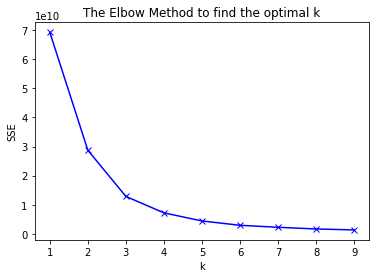

In [99]:
sse = []
ks = range(1,10)

for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(monetary[["total"]])

    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)

print(pd.DataFrame(dict(k=ks, sse=sse)))

plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method to find the optimal k')
plt.show()

In [100]:
kmeans = KMeans(n_clusters=5, random_state=123)
kmeans.fit(monetary[["total"]])
monetary["mc"] = kmeans.predict(monetary[["total"]])

In [101]:
monetary.head()

,total,mc
acn,,
11,1275.00,0
17,49.50,0
23,2640.54,0
33,3782.62,2
34,7798.28,2


In [102]:
monetary.groupby("mc").total.describe()

,count,mean,std,min,25%,50%,75%,max
mc,,,,,,,,
0,2288.0,491.115782,718.544964,1.00,47.6700,187.210,592.7100,3410.00
1,31.0,30121.121613,5681.948053,22770.36,25473.8900,28946.780,33216.2100,45110.68
2,325.0,6365.756369,1931.065347,3443.05,4678.1100,6297.400,7868.2600,10205.57
3,4.0,68343.170000,10567.694244,57203.88,60409.8375,68944.195,76877.5275,78280.41
4,77.0,14139.440260,3091.434680,10345.25,11196.0700,13462.400,16065.8200,20862.18


In [103]:
condition = [monetary.mc == 0,monetary.mc == 1,monetary.mc == 2,monetary.mc == 3,monetary.mc == 4]
choice = [5,2,4,1,3]
monetary["mon_srtd"] = np.select(condition,choice,"nan")

In [104]:
monetary = monetary.drop(columns="mc")
monetary.rename(columns={"mon_srtd":"monetary_cluster"},inplace=True)

monetary.head()

,total,monetary_cluster
acn,,
11,1275.00,5
17,49.50,5
23,2640.54,5
33,3782.62,4
34,7798.28,4


### Monetary Clusters
- 1: Very High Spender
- 2: High Spender
- 3: Average Spender
- 4: Low Spender
- 5: Minimum Spender

In [105]:
monetary.monetary_cluster.value_counts()

5    2288
4     325
3      77
2      31
1       4
Name: monetary_cluster, dtype: int64

## Combining RFM

In [534]:
rfm = customer.join([frequency,monetary])

In [535]:
rfm.head()

,timestamp,recency,recency_cluster,frequency,frequency_cluster,total,monetary_cluster
acn,,,,,,,
11,2019-12-31 14:01:00,0,1,169,2,1275.00,5
17,2015-04-04 11:32:00,1732,4,2,4,49.50,5
23,2019-12-20 12:10:00,11,1,148,2,2640.54,5
33,2019-12-31 00:00:00,0,1,56,3,3782.62,4
34,2018-09-30 00:00:00,457,2,34,4,7798.28,4


In [536]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2725 entries, 11 to 5434
Data columns (total 7 columns):
timestamp            2725 non-null datetime64[ns]
recency              2725 non-null int64
recency_cluster      2725 non-null int64
frequency            2725 non-null int64
frequency_cluster    2725 non-null object
total                2725 non-null float64
monetary_cluster     2725 non-null object
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 250.3+ KB


In [537]:
rfm.recency_cluster = rfm.recency_cluster.astype("int")
rfm.monetary_cluster = rfm.monetary_cluster.astype("int")
rfm.frequency_cluster = rfm.frequency_cluster.astype("int")

In [538]:
rfm["rfm_score"] = rfm.recency_cluster + rfm.frequency_cluster + rfm.monetary_cluster

In [539]:
rfm.rfm_score.value_counts().sort_values()

3       2
4      15
5      26
6      39
7      67
9     142
8     194
12    353
13    481
11    549
10    857
Name: rfm_score, dtype: int64

(array([  2.,  15.,  26.,  39.,  67., 194., 142., 857., 549., 834.]),
 array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.]),
 <a list of 10 Patch objects>)

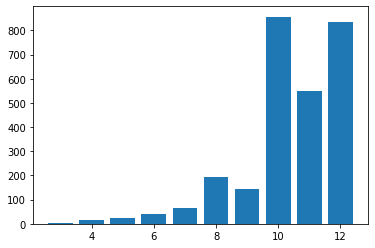

In [540]:
plt.hist(rfm.rfm_score,rwidth=0.8,align="left")

### RFM Score Range:
- 3-7 = High Value
- 8-9 = Mid Value
- 10-12 = Low Value

In [541]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2725 entries, 11 to 5434
Data columns (total 8 columns):
timestamp            2725 non-null datetime64[ns]
recency              2725 non-null int64
recency_cluster      2725 non-null int64
frequency            2725 non-null int64
frequency_cluster    2725 non-null int64
total                2725 non-null float64
monetary_cluster     2725 non-null int64
rfm_score            2725 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(6)
memory usage: 271.6 KB


## Tenure

In [542]:
tenure = df.copy()

In [543]:
tenure.head()

,acn,trans_id,timestamp,item,item_group,total,membership,group,city,state,zipcode,lat,long,category
0,11,37777,2015-08-12 16:03:00,Core Power,Beverage,2.80,Misc. Membership,NaN,NaN,NaN,NaN,NaN,NaN,Bar
1,11,38361,2015-08-21 08:02:00,Berries Amore,Beverage,4.28,Misc. Membership,NaN,NaN,NaN,NaN,NaN,NaN,Bar
2,11,38360,2015-08-21 08:02:00,Smoothie Add-On,Beverage,0.67,Misc. Membership,NaN,NaN,NaN,NaN,NaN,NaN,Bar
3,11,35130,2015-07-24 11:53:00,$2.00 Ice Cream,Food & Consumables,2.00,Misc. Membership,NaN,NaN,NaN,NaN,NaN,NaN,Bar
4,11,35131,2015-07-24 11:53:00,$2.00 Ice Cream,Food & Consumables,2.00,Misc. Membership,NaN,NaN,NaN,NaN,NaN,NaN,Bar


In [544]:
tenure.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141967 entries, 0 to 141966
Data columns (total 14 columns):
acn           141967 non-null int64
trans_id      141967 non-null int64
timestamp     141967 non-null datetime64[ns]
item          141967 non-null object
item_group    141967 non-null object
total         141967 non-null float64
membership    141967 non-null object
group         22110 non-null object
city          22097 non-null object
state         22110 non-null object
zipcode       22110 non-null float64
lat           22110 non-null float64
long          22110 non-null float64
category      141967 non-null object
dtypes: datetime64[ns](1), float64(4), int64(2), object(7)
memory usage: 15.2+ MB


In [545]:
start = tenure.groupby("acn")[["timestamp"]].min().rename(columns={"timestamp":"start"})

In [546]:
start.shape

(2725, 1)

In [547]:
end = tenure.groupby("acn")[["timestamp"]].max().rename(columns={"timestamp":"end"})

In [548]:
end.shape

(2725, 1)

In [549]:
rfm = rfm.join([start,end])

In [550]:
rfm

,timestamp,recency,recency_cluster,frequency,frequency_cluster,total,monetary_cluster,rfm_score,start,end
acn,,,,,,,,,,
11,2019-12-31 14:01:00,0,1,169,2,1275.00,5,8,2015-01-06 15:23:00,2019-12-31 14:01:00
17,2015-04-04 11:32:00,1732,4,2,4,49.50,5,13,2015-01-17 09:40:00,2015-04-04 11:32:00
23,2019-12-20 12:10:00,11,1,148,2,2640.54,5,8,2015-01-26 07:32:00,2019-12-20 12:10:00
33,2019-12-31 00:00:00,0,1,56,3,3782.62,4,8,2015-04-20 06:34:00,2019-12-31 00:00:00
34,2018-09-30 00:00:00,457,2,34,4,7798.28,4,10,2015-04-26 13:15:00,2018-09-30 00:00:00
42,2019-12-31 00:00:00,0,1,80,3,3367.82,5,9,2015-02-21 17:43:00,2019-12-31 00:00:00
47,2019-12-17 14:35:00,14,1,4,4,5611.16,4,9,2019-08-20 15:27:00,2019-12-17 14:35:00
55,2019-12-31 00:00:00,0,1,59,3,2902.69,5,9,2016-01-18 20:00:00,2019-12-31 00:00:00
64,2016-07-31 00:00:00,1248,3,19,4,2673.87,5,12,2015-01-31 00:00:00,2016-07-31 00:00:00


In [551]:
rfm["T"] = (rfm.end - rfm.start).dt.days

In [552]:
rfm[rfm.recency > rfm["T"]]

,timestamp,recency,recency_cluster,frequency,frequency_cluster,total,monetary_cluster,rfm_score,start,end,T
acn,,,,,,,,,,,
17,2015-04-04 11:32:00,1732,4,2,4,49.50,5,13,2015-01-17 09:40:00,2015-04-04 11:32:00,77
64,2016-07-31 00:00:00,1248,3,19,4,2673.87,5,12,2015-01-31 00:00:00,2016-07-31 00:00:00,547
65,2017-03-31 00:00:00,1005,3,28,4,3847.09,4,11,2015-01-31 00:00:00,2017-03-31 00:00:00,790
67,2017-04-30 00:00:00,975,3,42,3,5916.94,4,10,2015-01-31 00:00:00,2017-04-30 00:00:00,820
68,2015-11-30 00:00:00,1492,4,11,4,1548.03,5,13,2015-01-31 00:00:00,2015-11-30 00:00:00,303
70,2015-07-31 00:00:00,1614,4,4,4,562.92,5,13,2015-04-30 00:00:00,2015-07-31 00:00:00,92
72,2016-09-30 00:00:00,1187,3,21,4,2955.33,5,12,2015-01-31 00:00:00,2016-09-30 00:00:00,608
80,2015-11-30 00:00:00,1492,4,12,4,1566.43,5,13,2015-01-31 00:00:00,2015-11-30 00:00:00,303
82,2015-06-30 00:00:00,1645,4,9,4,889.96,5,13,2015-01-03 14:26:00,2015-06-30 00:00:00,177


---

In [1046]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans

from lifetimes import BetaGeoFitter
from lifetimes.utils import summary_data_from_transaction_data

import warnings
warnings.filterwarnings("ignore")

In [1036]:
df = pd.read_csv("main_df.csv", low_memory=False)
df.timestamp = pd.to_datetime(df.timestamp)

## BG/NBD Model

In [1143]:
rfm = summary_data_from_transaction_data(df.copy(),"acn","timestamp",monetary_value_col="total",observation_period_end=df.timestamp.max().date())

In [1144]:
rfm.head()

,frequency,recency,T,monetary_value
acn,,,,
11,166.0,1820.0,1820.0,7.676205
17,1.0,77.0,1809.0,9.500000
23,147.0,1789.0,1800.0,17.943810
33,55.0,1716.0,1716.0,68.529455
34,33.0,1253.0,1710.0,235.493333


In [1145]:
rfm = rfm[rfm.monetary_value>0]

In [1146]:
rfm.shape

(2028, 4)

---

In [1147]:
horizon = 730

In [1148]:
bgf = BetaGeoFitter(penalizer_coef=0.1)

In [1149]:
bgf.fit(rfm.frequency,rfm.recency,rfm["T"])

<lifetimes.BetaGeoFitter: fitted with 2028 subjects, a: 0.14, alpha: 15.70, b: 0.63, r: 0.72>

In [1150]:
rfm.shape

(2028, 4)

In [1151]:
rfm["predicted_purchase_count"] = bgf.predict(horizon,rfm.frequency,rfm.recency,rfm["T"])

In [1152]:
rfm.head()

,frequency,recency,T,monetary_value,predicted_purchase_count
acn,,,,,
11,166.0,1820.0,1820.0,7.676205,64.673878
17,1.0,77.0,1809.0,9.500000,0.017893
23,147.0,1789.0,1800.0,17.943810,57.836232
33,55.0,1716.0,1716.0,68.529455,22.839952
34,33.0,1253.0,1710.0,235.493333,0.103730


In [1153]:
# from lifetimes.plotting import plot_frequency_recency_matrix
# plot_frequency_recency_matrix(bgf)

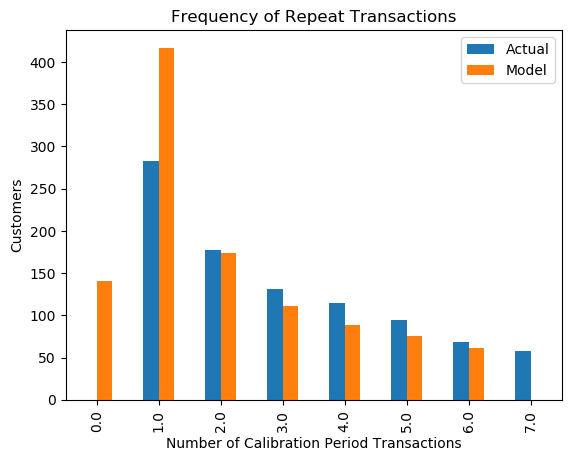

In [1154]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

## Fit BGF Including Calibration & Holdouts

In [1155]:
from lifetimes.utils import calibration_and_holdout_data

In [1156]:
rfm_cal = calibration_and_holdout_data(df.copy(),"acn","timestamp",calibration_period_end=(df.timestamp.quantile().date()),monetary_value_col="total",observation_period_end=(df.timestamp.max().date()))

In [1157]:
rfm_cal.head()

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
acn,,,,,,,
11,81.0,1081.0,1119.0,5.814321,84.0,7.512673,701
17,1.0,77.0,1108.0,9.500000,0.0,0.000000,701
23,26.0,1026.0,1099.0,27.794615,121.0,13.207448,701
33,12.0,970.0,1015.0,15.898333,43.0,49.699167,701
34,23.0,980.0,1009.0,219.281304,10.0,194.843571,701


In [1158]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

In [1159]:
bgf.fit(rfm_cal.frequency_cal,rfm_cal.recency_cal,rfm_cal["T_cal"])

<lifetimes.BetaGeoFitter: fitted with 1840 subjects, a: 0.10, alpha: 10.61, b: 0.52, r: 0.36>

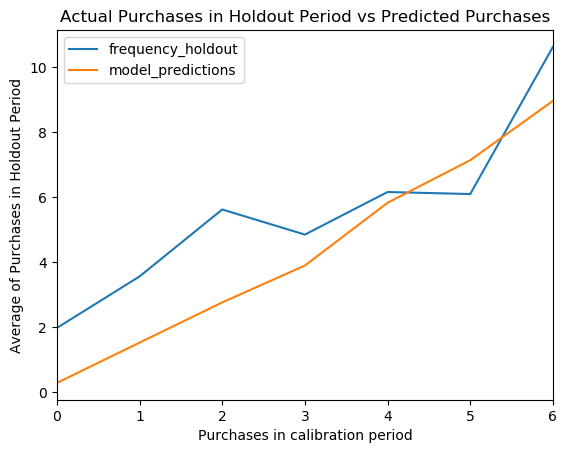

In [1160]:
plot_calibration_purchases_vs_holdout_purchases(bgf,rfm_cal)

## Gamma-Gamma Model

In [1161]:
rfm[["frequency","monetary_value"]].corr()

,frequency,monetary_value
frequency,1.000000,0.036856
monetary_value,0.036856,1.000000


In [1162]:
from lifetimes import GammaGammaFitter

In [1163]:
ggf = GammaGammaFitter(penalizer_coef=0)
ggf.fit(rfm.frequency,rfm.monetary_value)

<lifetimes.GammaGammaFitter: fitted with 2028 subjects, p: 0.45, q: 1.92, v: 172.94>

In [1164]:
rfm["conditional_expected_ave_profit"] = ggf.conditional_expected_average_profit(rfm.frequency,rfm.monetary_value)

## CLV with Discounted Cash Flow

In [1165]:
bgf.fit(rfm.frequency,rfm.recency,rfm["T"])

<lifetimes.BetaGeoFitter: fitted with 2028 subjects, a: 0.14, alpha: 15.70, b: 0.63, r: 0.72>

In [1166]:
rfm["clv"] = ggf.customer_lifetime_value(bgf,rfm.frequency,rfm.recency,rfm["T"],rfm.monetary_value,time=12)

In [1167]:
rfm["clv_2"] = ggf.customer_lifetime_value(bgf,rfm.frequency,rfm.recency,rfm["T"],rfm.monetary_value,time=24)
rfm["clv_3"] = ggf.customer_lifetime_value(bgf,rfm.frequency,rfm.recency,rfm["T"],rfm.monetary_value,time=36)
rfm["clv_4"] = ggf.customer_lifetime_value(bgf,rfm.frequency,rfm.recency,rfm["T"],rfm.monetary_value,time=48)
rfm["clv_5"] = ggf.customer_lifetime_value(bgf,rfm.frequency,rfm.recency,rfm["T"],rfm.monetary_value,time=60)

In [1168]:
rfm.describe().T

,count,mean,std,min,25%,50%,75%,max
frequency,2028.0,34.872288,67.508687,1.000000e+00,3.000000,9.000000,35.000000,599.000000
recency,2028.0,705.579389,581.873448,1.000000e+00,182.000000,554.500000,1182.000000,1825.000000
T,2028.0,1153.248028,579.571689,3.000000e+00,622.750000,1285.000000,1716.000000,1825.000000
monetary_value,2028.0,66.331892,74.384253,9.000000e-01,18.940536,52.326909,98.897977,2032.620000
predicted_purchase_count,2028.0,16.460131,30.711408,8.806728e-76,0.037193,2.156324,17.829146,232.801104
conditional_expected_ave_profit,2028.0,72.357234,46.064063,7.222962e+00,42.605732,61.759238,94.792348,724.983091
clv,2028.0,562.237252,1164.001885,3.321839e-74,1.190357,57.139607,454.888100,14061.540076
clv_2,2028.0,1038.628040,2157.153275,6.204093e-74,2.217831,106.310919,822.997226,26261.161616
clv_3,2028.0,1448.465381,3014.921387,8.713010e-74,3.102121,147.518330,1144.468432,36879.851539
clv_4,2028.0,1803.415657,3759.766947,1.090223e-73,3.868670,183.452454,1430.148843,46144.978483


(array([1.695e+03, 2.370e+02, 5.700e+01, 2.300e+01, 7.000e+00, 5.000e+00,
        0.000e+00, 3.000e+00, 0.000e+00, 1.000e+00]),
 array([3.32183867e-74, 1.40615401e+03, 2.81230802e+03, 4.21846202e+03,
        5.62461603e+03, 7.03077004e+03, 8.43692405e+03, 9.84307805e+03,
        1.12492321e+04, 1.26553861e+04, 1.40615401e+04]),
 <a list of 10 Patch objects>)

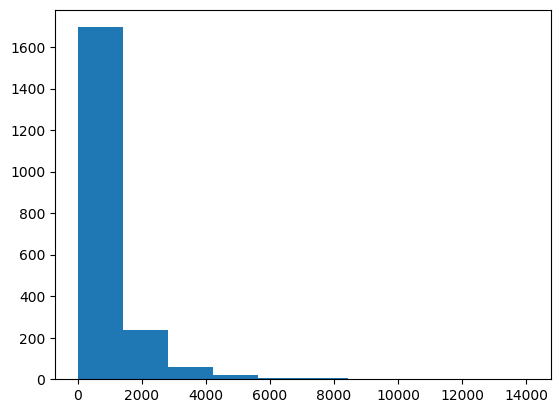

In [1169]:
plt.hist(rfm.clv)

## KMeans to cluster based on CLVs

In [1170]:
from sklearn.cluster import KMeans

In [1171]:
kmeans = KMeans(n_clusters=4,random_state=123)
rfm["clusters"] = kmeans.fit_predict(rfm[["recency","clv"]])

In [1172]:
rfm.groupby("clusters").clv.describe()

,count,mean,std,min,25%,50%,75%,max
clusters,,,,,,,,
0,573.0,190.718344,267.656350,2.922224e-34,21.523267,77.280082,226.908637,1207.927577
1,320.0,2133.225023,650.260718,1.185060e+03,1688.378479,1959.166457,2405.686542,4054.668893
2,1095.0,94.289255,206.641664,3.321839e-74,0.151159,7.427240,82.994311,1300.584039
3,40.0,6126.419833,2128.992594,4.194022e+03,4676.303434,5391.478756,6804.283439,14061.540076


In [1173]:
condition = [rfm.clusters==0,rfm.clusters==1,rfm.clusters==2,rfm.clusters==3]
choice = ["Silver","Gold","Bronze","Platinum"]
rfm["loyalty"] = np.select(condition,choice,"nan")

In [1174]:
rfm.loyalty.value_counts()

Bronze      1095
Silver       573
Gold         320
Platinum      40
Name: loyalty, dtype: int64

In [1175]:
rfm.head()

,frequency,recency,T,monetary_value,predicted_purchase_count,conditional_expected_ave_profit,clv,clv_2,clv_3,clv_4,clv_5,clusters,loyalty
acn,,,,,,,,,,,,,
11,166.0,1820.0,1820.0,7.676205,64.673878,8.612054,260.652671,486.825202,683.709710,855.511635,1005.707143,0,Silver
17,1.0,77.0,1809.0,9.500000,0.017893,59.968895,0.504862,0.938407,1.312908,1.637755,1.920403,2,Bronze
23,147.0,1789.0,1800.0,17.943810,57.836232,18.858271,510.479652,953.332353,1338.775229,1675.071650,1969.045252,0,Silver
33,55.0,1716.0,1716.0,68.529455,22.839952,69.107734,739.183534,1379.716564,1936.754629,2422.462906,2846.836332,0,Silver
34,33.0,1253.0,1710.0,235.493333,0.103730,226.704200,11.014357,20.555990,28.852112,36.084752,42.403275,0,Silver


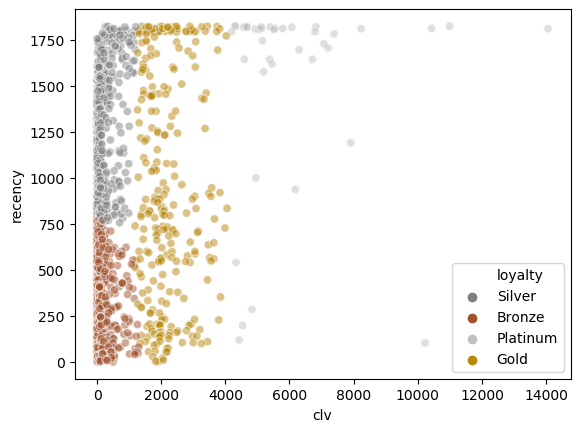

In [1176]:
sns.scatterplot(data=rfm,x="clv",y="recency",hue="loyalty",alpha=0.5,palette=['gray','sienna',"silver",'darkgoldenrod'])

## Membership

In [1177]:
membership = df.copy()

In [1178]:
membership.head()

,acn,trans_id,timestamp,item,item_group,total,membership,group,city,state,zipcode,lat,long,category
0,11,37777,2015-08-12 16:03:00,Core Power,Beverage,2.80,Misc. Membership,NaN,NaN,NaN,NaN,NaN,NaN,Bar
1,11,38361,2015-08-21 08:02:00,Berries Amore,Beverage,4.28,Misc. Membership,NaN,NaN,NaN,NaN,NaN,NaN,Bar
2,11,38360,2015-08-21 08:02:00,Smoothie Add-On,Beverage,0.67,Misc. Membership,NaN,NaN,NaN,NaN,NaN,NaN,Bar
3,11,35130,2015-07-24 11:53:00,$2.00 Ice Cream,Food & Consumables,2.00,Misc. Membership,NaN,NaN,NaN,NaN,NaN,NaN,Bar
4,11,35131,2015-07-24 11:53:00,$2.00 Ice Cream,Food & Consumables,2.00,Misc. Membership,NaN,NaN,NaN,NaN,NaN,NaN,Bar


In [1179]:
mem = membership.groupby(["acn","membership","timestamp"])[["trans_id"]].count().sort_values(by=["acn","timestamp"],ascending=False).reset_index()
mem = mem.drop_duplicates(subset="acn",keep="first").set_index("acn")
mem = mem[["membership"]]

In [1180]:
mem.head()

,membership
acn,
5434,General Family Membership
5428,General Family Membership
5425,General Family Membership
5424,General Family Membership
5397,Guest


### Join membership type with rfm

In [1181]:
rfmdf = rfm.copy().join(mem)

In [1182]:
rfmdf.shape

(2028, 14)

In [1183]:
rfmdf.head()

,frequency,recency,T,monetary_value,predicted_purchase_count,conditional_expected_ave_profit,clv,clv_2,clv_3,clv_4,clv_5,clusters,loyalty,membership
acn,,,,,,,,,,,,,,
11,166.0,1820.0,1820.0,7.676205,64.673878,8.612054,260.652671,486.825202,683.709710,855.511635,1005.707143,0,Silver,Misc. Membership
17,1.0,77.0,1809.0,9.500000,0.017893,59.968895,0.504862,0.938407,1.312908,1.637755,1.920403,2,Bronze,Guest
23,147.0,1789.0,1800.0,17.943810,57.836232,18.858271,510.479652,953.332353,1338.775229,1675.071650,1969.045252,0,Silver,Misc. Membership
33,55.0,1716.0,1716.0,68.529455,22.839952,69.107734,739.183534,1379.716564,1936.754629,2422.462906,2846.836332,0,Silver,General Family Membership
34,33.0,1253.0,1710.0,235.493333,0.103730,226.704200,11.014357,20.555990,28.852112,36.084752,42.403275,0,Silver,General Family Membership


In [1184]:
rfmdf.loyalty.value_counts()

Bronze      1095
Silver       573
Gold         320
Platinum      40
Name: loyalty, dtype: int64

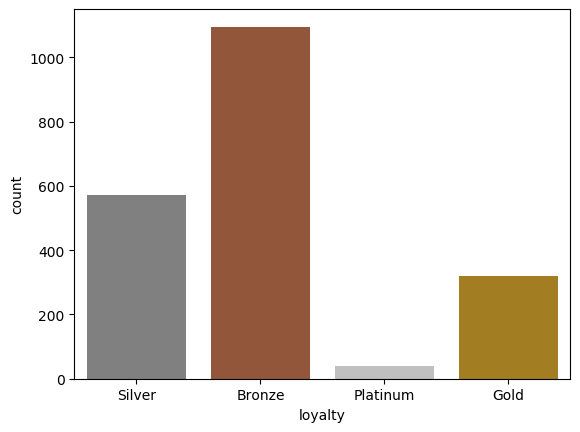

In [1185]:
sns.countplot(x="loyalty",data=rfmdf,palette=['gray','sienna',"silver",'darkgoldenrod'])

In [1186]:
rfmdf.groupby("loyalty").clv.describe().reset_index()

,loyalty,count,mean,std,min,25%,50%,75%,max
0,Bronze,1095.0,94.289255,206.641664,3.321839e-74,0.151159,7.427240,82.994311,1300.584039
1,Gold,320.0,2133.225023,650.260718,1.185060e+03,1688.378479,1959.166457,2405.686542,4054.668893
2,Platinum,40.0,6126.419833,2128.992594,4.194022e+03,4676.303434,5391.478756,6804.283439,14061.540076
3,Silver,573.0,190.718344,267.656350,2.922224e-34,21.523267,77.280082,226.908637,1207.927577


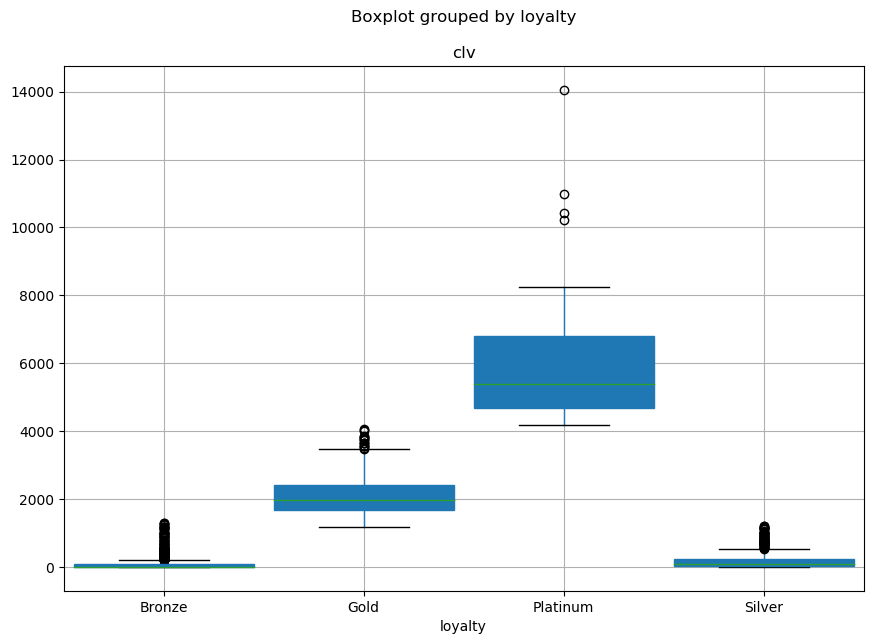

In [1117]:
rfm.boxplot(column="clv",by="loyalty",figsize=(10,7),widths=.9,meanline=True,patch_artist=True) 
plt.show()

In [1187]:
member_loyalty = pd.crosstab(rfmdf.membership,rfmdf.loyalty).apply(lambda r: r/r.sum(), axis=1)
member_loyalty = member_loyalty[["Bronze","Silver","Gold","Platinum"]]

In [1188]:
member_loyalty

loyalty,Bronze,Silver,Gold,Platinum
membership,,,,
General Family Membership,0.479185,0.279008,0.211692,0.030115
General Property Owner,0.501639,0.442623,0.052459,0.003279
General Single Membership,0.252874,0.275862,0.459770,0.011494
Guest,0.833333,0.146465,0.020202,0.000000
Misc. Membership,0.633333,0.366667,0.000000,0.000000
ND Owner Membership,0.375000,0.625000,0.000000,0.000000
Premier Family Membership,0.352941,0.367647,0.235294,0.044118
Premier Single Membership,0.500000,0.000000,0.000000,0.500000
Veramendi Teacher,0.666667,0.000000,0.333333,0.000000


In [1190]:
from matplotlib import colors
cmap = colors.ListedColormap(['sienna',"gray",'darkgoldenrod','silver'])

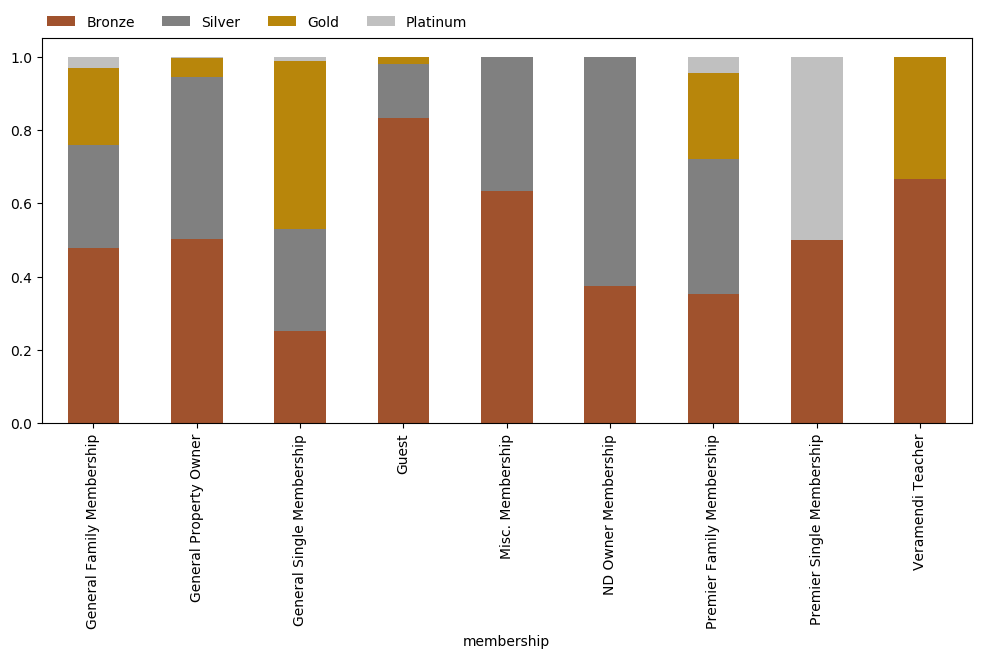

In [1191]:
ax = member_loyalty.plot(kind="bar",stacked=True,cmap=cmap,figsize=(12,5),legend=True)
ax.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=4, borderaxespad=0, frameon=False)
plt.show()

In [1196]:
rfmdf["churn_probability"] = np.where((rfmdf.predicted_purchase_count < 1),"likely_churner","likely_stayer")

In [1197]:
rfmdf

,frequency,recency,T,monetary_value,predicted_purchase_count,conditional_expected_ave_profit,clv,clv_2,clv_3,clv_4,clv_5,clusters,loyalty,membership,churn_probability
acn,,,,,,,,,,,,,,,
11,166.0,1820.0,1820.0,7.676205,6.467388e+01,8.612054,2.606527e+02,4.868252e+02,6.837097e+02,8.555116e+02,1.005707e+03,0,Silver,Misc. Membership,likely_stayer
17,1.0,77.0,1809.0,9.500000,1.789340e-02,59.968895,5.048624e-01,9.384074e-01,1.312908e+00,1.637755e+00,1.920403e+00,2,Bronze,Guest,likely_churner
23,147.0,1789.0,1800.0,17.943810,5.783623e+01,18.858271,5.104797e+02,9.533324e+02,1.338775e+03,1.675072e+03,1.969045e+03,0,Silver,Misc. Membership,likely_stayer
33,55.0,1716.0,1716.0,68.529455,2.283995e+01,69.107734,7.391835e+02,1.379717e+03,1.936755e+03,2.422463e+03,2.846836e+03,0,Silver,General Family Membership,likely_stayer
34,33.0,1253.0,1710.0,235.493333,1.037300e-01,226.704200,1.101436e+01,2.055599e+01,2.885211e+01,3.608475e+01,4.240328e+01,0,Silver,General Family Membership,likely_churner
42,76.0,1774.0,1774.0,44.192105,3.047524e+01,45.251642,6.455742e+02,1.205405e+03,1.692521e+03,2.117434e+03,2.488808e+03,0,Silver,General Family Membership,likely_stayer
47,3.0,119.0,133.0,1004.386667,1.428148e+01,631.883998,4.432523e+03,7.926420e+03,1.084323e+04,1.332573e+04,1.545971e+04,3,Platinum,General Family Membership,likely_stayer
55,58.0,1443.0,1443.0,49.115345,2.846046e+01,50.325064,6.719917e+02,1.252205e+03,1.755507e+03,2.193532e+03,2.575686e+03,0,Silver,General Single Membership,likely_stayer
64,18.0,547.0,1795.0,140.730000,3.013943e-07,135.018901,1.905497e-05,3.557071e-05,4.993591e-05,6.246312e-05,7.340942e-05,2,Bronze,General Family Membership,likely_churner


In [1244]:
churn_matrix = pd.crosstab(index=rfmdf.churn_probability, columns=rfmdf.loyalty).apply(lambda c: c/c.sum()*100, axis=0)

In [1245]:
churn_matrix.head()

loyalty,Bronze,Gold,Platinum,Silver
churn_probability,,,,
likely_churner,63.013699,0.0,0.0,26.701571
likely_stayer,36.986301,100.0,100.0,73.298429


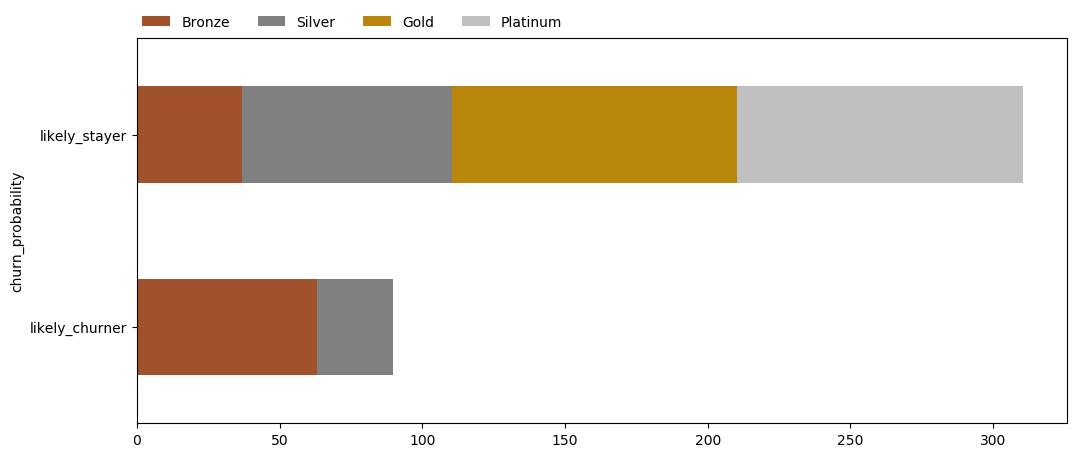

In [1248]:
ax = churn_matrix.plot(kind="barh",y=["Bronze","Silver","Gold","Platinum"],stacked=True,cmap=cmap,figsize=(12,5),legend=True)
ax.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=4, borderaxespad=0, frameon=False)
plt.show()

In [1251]:
member_churn = pd.crosstab(rfmdf.membership,rfmdf.churn_probability).apply(lambda r: r/r.sum(), axis=1)

In [1252]:
member_churn

churn_probability,likely_churner,likely_stayer
membership,,
General Family Membership,0.408326,0.591674
General Property Owner,0.262295,0.737705
General Single Membership,0.356322,0.643678
Guest,0.593434,0.406566
Misc. Membership,0.233333,0.766667
ND Owner Membership,0.250000,0.750000
Premier Family Membership,0.382353,0.617647
Premier Single Membership,0.500000,0.500000
Veramendi Teacher,0.000000,1.000000


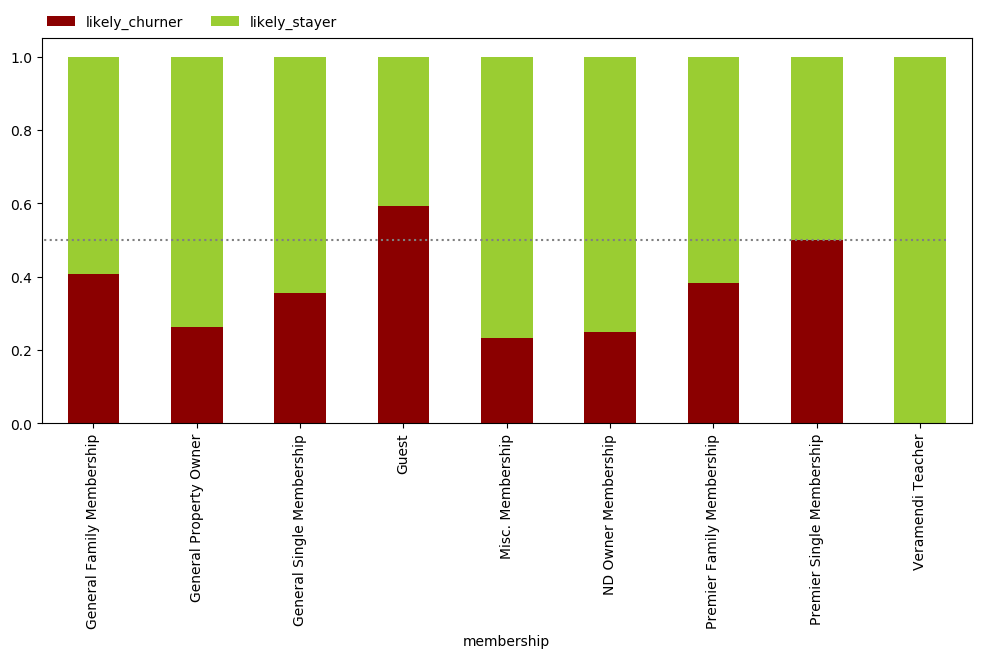

In [1270]:
nogo = colors.ListedColormap(["darkred","yellowgreen"])
ax = member_churn.plot(kind="bar",stacked=True,cmap=nogo,figsize=(12,5),legend=True)
ax.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=4, borderaxespad=0, frameon=False)

plt.hlines(y=0.5,xmin=-0.9,xmax=8.25,colors="gray",linestyles=":")
plt.show()

---
## Sales Forecast

In [1552]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from fbprophet import Prophet


%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn import metrics

In [1644]:
df = pd.read_csv("main_df.csv", low_memory=False)
df.timestamp = pd.to_datetime(df.timestamp)

In [1645]:
df.category.unique()

array(['Bar', 'Pro Shop', 'Event', 'Program', 'Tennis', 'Admin',
       'Fitness'], dtype=object)

### Clean up DF

In [1646]:
df.item_group[df.category=="Tennis"].unique()

array(['Adult Clinics', 'Tennis Lessons', 'Leagues', 'Junior Clinics',
       'Court Time'], dtype=object)

In [1647]:
df.category = np.where(df.item_group == "Court Time", "Admin", df.category)

In [1648]:
d = df.copy()
d.rename(columns={"timestamp":"ds","total":"y"},inplace=True)

In [1649]:
d.head()

,acn,trans_id,ds,item,item_group,y,membership,group,city,state,zipcode,lat,long,category
0,11,37777,2015-08-12 16:03:00,Core Power,Beverage,2.80,Misc. Membership,NaN,NaN,NaN,NaN,NaN,NaN,Bar
1,11,38361,2015-08-21 08:02:00,Berries Amore,Beverage,4.28,Misc. Membership,NaN,NaN,NaN,NaN,NaN,NaN,Bar
2,11,38360,2015-08-21 08:02:00,Smoothie Add-On,Beverage,0.67,Misc. Membership,NaN,NaN,NaN,NaN,NaN,NaN,Bar
3,11,35130,2015-07-24 11:53:00,$2.00 Ice Cream,Food & Consumables,2.00,Misc. Membership,NaN,NaN,NaN,NaN,NaN,NaN,Bar
4,11,35131,2015-07-24 11:53:00,$2.00 Ice Cream,Food & Consumables,2.00,Misc. Membership,NaN,NaN,NaN,NaN,NaN,NaN,Bar


### Separate Targets

In [1687]:
dfbar = d[d.category == "Bar"].set_index("ds").resample("D").sum()[["y"]].reset_index()
dfps = d[d.category == "Pro Shop"].set_index("ds").resample("D").sum()[["y"]].reset_index()
dfprog = d[d.category == "Program"].set_index("ds").resample("D").sum()[["y"]].reset_index()
dftennis = d[d.category == "Tennis"].set_index("ds").resample("D").sum()[["y"]].reset_index()
dfadmin = d[d.category == "Admin"].set_index("ds").resample("D").sum()[["y"]].reset_index()
dffitness = d[d.category == "Fitness"].set_index("ds").resample("D").sum()[["y"]].reset_index()
dfevent = d[d.category == "Event"].set_index("ds").resample("D").sum()[["y"]].reset_index()

In [1651]:
thanksgiving = pd.DataFrame({
  'holiday': 'thanksgiving',
  'ds': pd.to_datetime(['2015-11-26','2016-11-24', '2017-11-23','2018-11-22','2019-11-28']),
  'lower_window': -1,
  'upper_window': 1,
})
christmas = pd.DataFrame({
  'holiday': 'christmas',
  'ds': pd.to_datetime(['2015-12-25','2016-12-25', '2017-12-25','2018-12-25', '2019-12-25']),
  'lower_window': -1,
  'upper_window': 1,
})
newyears = pd.DataFrame({
  'holiday': 'newyears',
  'ds': pd.to_datetime(['2015-01-01', '2016-01-01','2017-01-01', '2018-01-01','2019-01-01']),
  'lower_window': -1,
  'upper_window': 0,
})

holidays = pd.concat((thanksgiving, christmas, newyears))

### Bar Analysis

### Moving Average

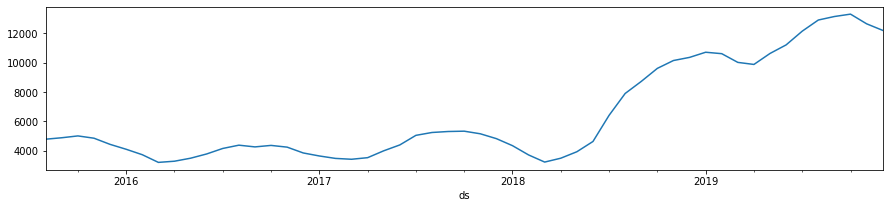

In [1652]:
bar_rolling = dfbar.set_index("ds").resample('M').sum().rolling(8, min_periods=8).mean().dropna()
bar_rolling.y.plot(figsize=(15, 3), legend=False)
plt.show()

In [1653]:
def evaluate(y,yhat):
    mse = metrics.mean_squared_error(y,yhat)
    rmse = math.sqrt(mse)
    return rmse

In [1678]:
#FUNCTION
def prophet_me(df,cap,eval_sample,plot_title):
    
    df["cap"] = cap
    df["floor"] = df["y"].min()
    
    proph = Prophet(daily_seasonality=True, growth = "logistic", seasonality_mode="multiplicative", changepoint_range=0.9, holidays = holidays)
    proph.fit(df)

    future = proph.make_future_dataframe(periods=366,freq="D")
    future['cap'] = cap
    future['floor'] = df["y"].min()
    
    forecast = proph.predict(future)
    
    plt.figure(figsize=(15, 3))
    plt.plot(df.set_index("ds").resample("M").sum()[["y"]],label="actual")
    plt.plot(forecast.set_index("ds").resample("M").sum()[["yhat"]],label="predicted")

    plt.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=4, borderaxespad=0, frameon=False)
    plt.title(plot_title)
    
    plt.show()
    
    rmse = evaluate(df["y"].head(eval_sample),forecast["yhat"].sample(eval_sample))
    
    print(f"Root Mean Squared Error of Forecast: ${rmse}")
    
    return future,forecast,rmse

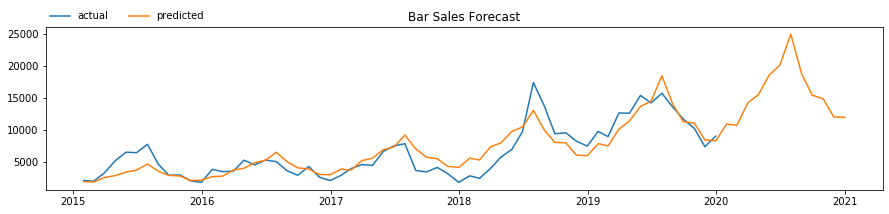

Root Mean Squared Error of Forecast: $282.4595314547198


In [1679]:
future_bar,forecast_bar,rmse_bar = prophet_me(dfbar,3000,1800,"Bar Sales Forecast")

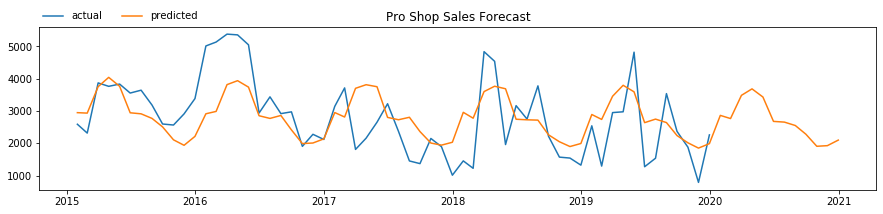

Root Mean Squared Error of Forecast: $137.416269446065


In [1680]:
future_ps,forecast_ps,rmse_ps = prophet_me(dfps,3000,1800,"Pro Shop Sales Forecast")

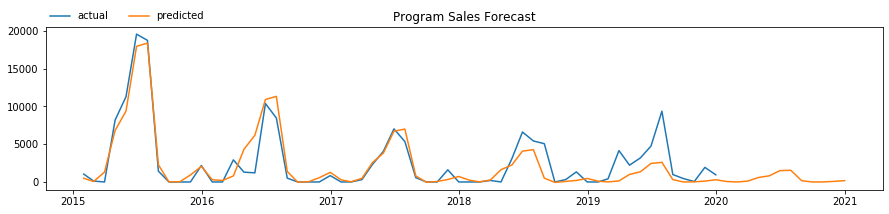

Root Mean Squared Error of Forecast: $328.48333074213934


In [1681]:
future_prog,forecast_prog,rmse_prog = prophet_me(dfprog,6000,1800,"Program Sales Forecast")

In [1682]:
dftennis.y.max()

7755.0

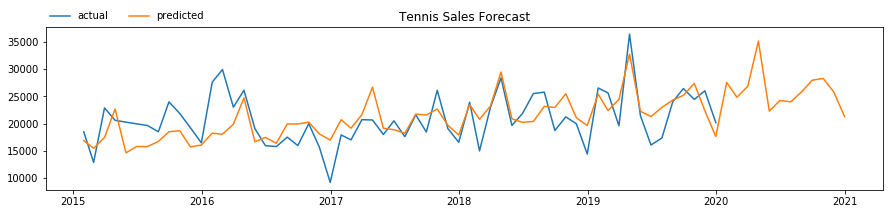

Root Mean Squared Error of Forecast: $1001.0705408102273


In [1683]:
future_tennis,forecast_tennis,rmse_tennis = prophet_me(dftennis,10000,1800,"Tennis Sales Forecast")

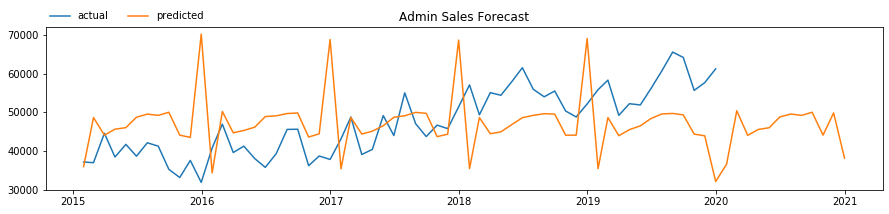

Root Mean Squared Error of Forecast: $7698.863040910055


In [1684]:
future_admin,forecast_admin,rmse_admin = prophet_me(dfadmin,10000,1800,"Admin Sales Forecast")

In [1685]:
dffitness.y.max()

9857.0

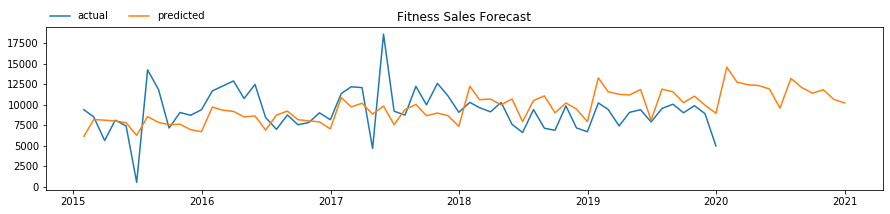

Root Mean Squared Error of Forecast: $966.0929932483762


In [1686]:
future_fitness,forecast_fitness,rmse_fitness= prophet_me(dffitness,5000,1800,"Fitness Sales Forecast")

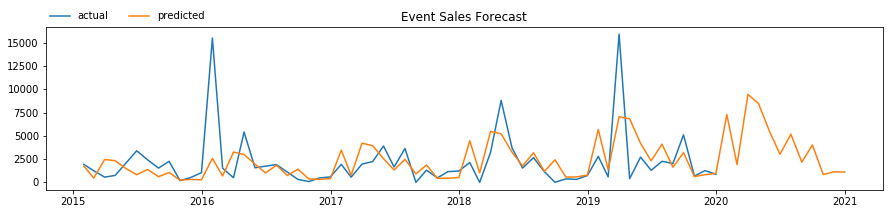

Root Mean Squared Error of Forecast: $364.94280973245327


In [1688]:
future_event,forecast_event,rmse_event= prophet_me(dfevent,5000,1800,"Event Sales Forecast")

In [1715]:
fc = {"bar":forecast_bar,"ps":forecast_ps,"prog":forecast_prog,"tennis":forecast_tennis,"fitness":forecast_fitness,"admin":forecast_admin,"event":forecast_event}

In [1740]:
fc2 = []
for name,df in fc.items():
    df = df.set_index("ds").loc["2020"][["yhat"]]
    fc2.append(df)
    print(name)

bar
ps
prog
tennis
fitness
admin
event


In [1744]:
fc_bar = fc2[0]
fc_ps = fc2[1]
fc_prog = fc2[2]
fc_tennis = fc2[3]
fc_fitness = fc2[4]
fc_admin = fc2[5]
fc_event = fc2[6]

In [1751]:
forecasts2020 = 

,yhat
ds,
2020-01-01,304.953234
2020-01-02,321.911858
2020-01-03,253.976846
2020-01-04,348.802245
2020-01-05,95.940186
2020-01-06,406.387264
2020-01-07,327.523073
2020-01-08,350.996554
2020-01-09,369.192356


In [1697]:
forecast_bar.set_index("ds").loc["2020"][["yhat"]]

,yhat
ds,
2020-01-01,304.953234
2020-01-02,321.911858
2020-01-03,253.976846
2020-01-04,348.802245
2020-01-05,95.940186
2020-01-06,406.387264
2020-01-07,327.523073
2020-01-08,350.996554
2020-01-09,369.192356


---
## Index for Building Prophet Function

In [1542]:
proph = Prophet(daily_seasonality=True,weekly_seasonality=True,growth = "logistic", changepoint_range=0.9, holidays = holidays)
proph.fit(dfbar)

In [1543]:
future = proph.make_future_dataframe(periods=366,freq="D")
future['cap'] = 3000
future['floor'] = dfbar.y.min()
print(future.head())
print(future.tail())
print(dfbar.tail())

          ds   cap  floor
0 2015-01-02  3000    0.0
1 2015-01-03  3000    0.0
2 2015-01-04  3000    0.0
3 2015-01-05  3000    0.0
4 2015-01-06  3000    0.0
             ds   cap  floor
2186 2020-12-27  3000    0.0
2187 2020-12-28  3000    0.0
2188 2020-12-29  3000    0.0
2189 2020-12-30  3000    0.0
2190 2020-12-31  3000    0.0
             ds       y      cap  floor
1820 2019-12-27  204.73  2328.18    0.0
1821 2019-12-28  326.71  2328.18    0.0
1822 2019-12-29   81.99  2328.18    0.0
1823 2019-12-30  978.50  2328.18    0.0
1824 2019-12-31  408.63  2328.18    0.0


In [1544]:
forecast = proph.predict(future).set_index("ds")

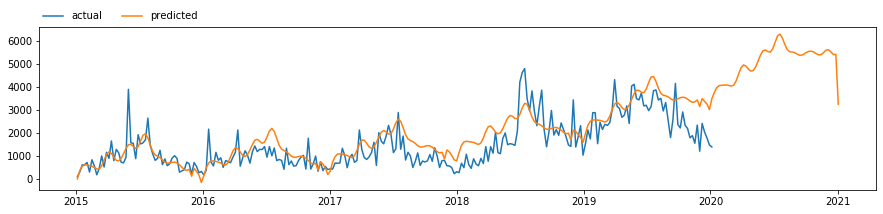

In [1606]:
plt.figure(figsize=(15, 3))
plt.plot(dfbar.set_index("ds").resample("W").sum()[["y"]],label="actual")
plt.plot(forecast.resample("W").sum()[["yhat"]],label="predicted")

plt.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=4, borderaxespad=0, frameon=False)
plt.show()

In [1558]:
dfbar.shape

(1825, 4)

In [1554]:
def evaluate(y,yhat):
    mse = metrics.mean_squared_error(y,yhat)
    rmse = math.sqrt(mse)
    return rmse

In [1555]:
evaluate(dfbar.y.head(300),forecast.yhat.head(300))

174.38096161244496

In [1559]:
evaluate(dfbar.y.head(1800),forecast.yhat.sample(1800))

329.5426626372335